# Project Stage - III (Basic Machine Learning)

### Import essential libraries

In [135]:
import os
import math
# Science libraries
import pandas as pd
import numpy as np
# Ploting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly
# Machine learning
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [136]:
# Create folder to hold the graphs
if not os.path.exists("images"):
    os.mkdir("images")

### Read and Filtter Dataset

#### Read dataset

In [202]:
# Read super Covid-19 dataframe with state as index. 
covid = pd.read_csv("../../../data/output/covid.csv", index_col=0)
# Read super Hosiptal dataframe with state as index. 
hospital = pd.read_csv("../../../data/output/COVID19_HOSBEDS_MERGE.csv", index_col=0)

In [138]:
FL_hospital = hospital.groupby('State').sum().loc['FL']

#### Clean the dataset.
remove unnessasery columns or rows.

In [139]:
# Drop unneccesary variables in Super covid-19 dataframe. 
covid.drop(["countyFIPS","stateFIPS"], axis=1, inplace=True)

# Drop unneccesary rows in Super COVID-19 dataframe.
covid.drop(
    covid.loc[covid['County Name'] == ("Statewide Unallocated" or 'New York City Unallocated')].index,
    inplace=True)

# Reset indexes after removing rows
covid.reset_index(drop=True, inplace=True)

#### Splite super covid dataset
Create dataframe that hold covid death and dataframe that hold covid cases.

In [140]:
# Regalare expression that will help filltering the data.
regex_cases = '(^[0-9]+[/]+[0-9]+[/]+[0-9]+[_]+[x])|^County Name$|^State$|^population$'
regex_deaths = '(^[0-9]+[/]+[0-9]+[/]+[0-9]+[_]+[y])|^County Name$|^State$|^population$'

cases = covid.filter(regex=regex_cases)
deaths = covid.filter(regex=regex_deaths)

Save the first three columns temprary so that we fix:
1. the date syntax.
2. Find the new cases/deaths

In [141]:
# Split the data: first three columns
covid_columns = covid[covid.columns[:3]]

# Split the data: fourth to the end columns
cases_data = cases[cases.columns[3:]]
deaths_data = deaths[deaths.columns[3:]]

#### Convert date type from String to Timestamp

In [142]:
# Fixing date string syntax
daily_cases = cases_data.rename(
    columns=lambda x: str(pd.to_datetime((x.split('_')[0]))).split(" ")[0],
    errors='raise')
daily_deaths = deaths_data.rename(
    columns=lambda x: str(pd.to_datetime((x.split('_')[0]))).split(" ")[0],
    errors='raise')

In [143]:
daily_cases

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14
0,0,0,0,0,0,0,0,0,0,0,...,2230,2242,2267,2283,2304,2328,2351,2385,2417,2435
1,0,0,0,0,0,0,0,0,0,0,...,7097,7134,7188,7226,7263,7348,7409,7454,7523,7596
2,0,0,0,0,0,0,0,0,0,0,...,1080,1090,1092,1095,1098,1107,1112,1113,1117,1123
3,0,0,0,0,0,0,0,0,0,0,...,907,917,924,926,932,948,961,966,973,978
4,0,0,0,0,0,0,0,0,0,0,...,2222,2253,2286,2297,2335,2378,2400,2429,2488,2518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,0,0,0,0,0,0,0,0,0,0,...,658,681,692,726,776,869,869,944,991,1075
3141,0,0,0,0,0,0,0,0,0,0,...,897,922,932,977,1007,1025,1025,1066,1108,1178
3142,0,0,0,0,0,0,0,0,0,0,...,529,542,544,551,568,627,627,664,686,729
3143,0,0,0,0,0,0,0,0,0,0,...,179,185,185,187,190,199,199,203,206,218


#### Find the daily new cases/death.
Calculate the diffrence between the current day and the day before it. The results is the new cases.

In [144]:
daily_cases = daily_cases.diff(axis=1).fillna(0)
daily_deaths = daily_deaths.diff(axis=1).fillna(0)

#### Merge the popolation, states and county names to the daily cases/deaths

In [145]:
new_cases = covid_columns.merge(daily_cases, left_index=True, right_index=True)
new_deaths = covid_columns.merge(daily_deaths, left_index=True, right_index=True)

In [146]:
new_cases.head()

,County Name,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14
0,Autauga County,AL,55869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,12.0,25.0,16.0,21.0,24.0,23.0,34.0,32.0,18.0
1,Baldwin County,AL,223234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36.0,37.0,54.0,38.0,37.0,85.0,61.0,45.0,69.0,73.0
2,Barbour County,AL,24686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,10.0,2.0,3.0,3.0,9.0,5.0,1.0,4.0,6.0
3,Bibb County,AL,22394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,7.0,2.0,6.0,16.0,13.0,5.0,7.0,5.0
4,Blount County,AL,57826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,31.0,33.0,11.0,38.0,43.0,22.0,29.0,59.0,30.0


In [147]:
new_deaths.head()

,County Name,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14
0,Autauga County,AL,55869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0
1,Baldwin County,AL,223234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Barbour County,AL,24686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bibb County,AL,22394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Blount County,AL,57826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0


## Linear regression models for predicting cases and deaths in Florida.

#### Florida cases

Filtter the dataset to get Florida state and it's counties

In [148]:
florida_cases_with_counties = new_cases.loc[new_cases['State'] == 'FL']
florida_deaths_with_counties = new_deaths.loc[new_deaths['State'] == 'FL']

In [149]:
florida_cases = pd.DataFrame(florida_cases_with_counties[florida_cases_with_counties.columns[3:]].sum(axis=0)).T
florida_deaths = pd.DataFrame(florida_deaths_with_counties[florida_deaths_with_counties.columns[3:]].sum(axis=0)).T

In [150]:
florida_cases =florida_cases.T
florida_deaths =florida_deaths.T

Fit a linewar regression model using sklearn's LinearRegression package

In [151]:
florida_cases_=florida_cases.reset_index().rename(columns={'index':'Date', 0:'Cases'})
florida_deaths_=florida_deaths.reset_index().rename(columns={'index':'Date', 0:'Deaths'})

In [152]:
florida_cases_

,Date,Cases
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
293,2020-11-10,4354.0
294,2020-11-11,5803.0
295,2020-11-12,5612.0
296,2020-11-13,6934.0


In [153]:
df = florida_cases_
X = df.index.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, df.Cases)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

fig = go.Figure()
cols = plotly.colors.DEFAULT_PLOTLY_COLORS

fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['Cases'],
        opacity=0.65,
        name="Cases",
        mode="markers",
        line=dict(width=2, color=cols[0]),
    ))
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=y_range,
        opacity=0.65,
        name='Regression Fit',
        line=dict(width=2, color=cols[0]),
    ))
# Set custom x-axis labels
fig.update_xaxes(
    tickvals=df.index[0::40],
    ticktext=df['Date'][0::40],
)
fig.show()
fig.write_image("images/fig.png")

In [154]:

mse = mean_squared_error(x_range, y_range)

rmse = math.sqrt(mse)
print(rmse)

3220.7832248027935


## Non-Linear regression models for predicting cases and deaths in Florida.

In [155]:
def format_coefs(coefs):
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

In [156]:
df = florida_cases_
X = df.index.values.reshape(-1, 1)

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

fig = px.scatter(df, x=df.index, y='Cases', opacity=0.65)
degrees = []
for degree in [1, 2, 3, 4, 5, 6]:
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, df.Cases)
    y_poly = model.predict(x_range_poly)

    equation = format_coefs(model.coef_.round(2))
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
    degrees.append(y_poly)
fig.show()
fig.write_image("images/fig2.png")

In [187]:
mse = mean_squared_error(x_range, degrees[4])

rmse = math.sqrt(mse)
print(rmse)

3846.779649625964


### Identify which counties are most at risk. Model for top 5 counties with cases within a state and observe their trends.

In [160]:
FL_cases = florida_cases_with_counties
FL_deaths = florida_deaths_with_counties

In [161]:
florida_cases_with_counties=florida_cases_with_counties.T
florida_deaths_with_counties=florida_deaths_with_counties.T

In [162]:
florida_cases_with_counties_ =florida_cases_with_counties[3:].reset_index().rename(columns={'index':'Date'})

In [163]:
# # Cases
Miami = FL_cases[(FL_cases['County Name'] == 'Miami-Dade County')][FL_cases.columns[3:]].T
Broward = FL_cases[(FL_cases['County Name'] == 'Broward County')][FL_cases.columns[3:]].T
Orange = FL_cases[(FL_cases['County Name'] == 'Orange County')][FL_cases.columns[3:]].T
Palm =FL_cases[(FL_cases['County Name'] == 'Palm Beach County')][FL_cases.columns[3:]].T
Gadsden = FL_cases[(FL_cases['County Name'] == 'Gadsden County')][FL_cases.columns[3:]].T

# # Deaths
Union_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Union County')][FL_deaths.columns[3:]].T
Madison_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Madison County')][FL_deaths.columns[3:]].T
Lafayette_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Lafayette County')][FL_deaths.columns[3:]].T
Gilchrist_Deaths =FL_deaths[(FL_deaths['County Name'] == 'Gilchrist County')][FL_deaths.columns[3:]].T
Calhoun_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Calhoun County')][FL_deaths.columns[3:]].T

In [164]:
fig = go.Figure()
days = florida_cases_with_counties_.index.values.reshape(-1, 1)
def draw(df, name):
    X = days

    model = LinearRegression()
    model.fit(X, df.values.reshape(-1, 1))

    x_range = np.linspace(X.min(), X.max(), df.size)
    y_range = model.predict(x_range.reshape(-1, 1))
    color1 = list(np.random.choice(range(256), size=3))
    Y_Range = pd.Series(y_range[:,0], index=df.index)
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[df.columns[0]],
            opacity=0.65,
            name=name,
            mode="markers",
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=Y_Range,
            opacity=0.65,
            name='Regression ' + name,
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
# # Set custom x-axis labels
# fig.update_xaxes(
#     tickvals=df.index[0::40],
#     ticktext=df['Date'][0::40],
# )


draw(Miami, 'Miami-Dade')
draw(Broward, 'Broward')
draw(Orange, 'Orange')
draw(Palm, 'Palm Beach')
draw(Gadsden, 'Gadsden')


fig.show()
fig.write_image("images/fig3.png")


Florida's counties

In [165]:
fig = go.Figure()
for i in range(322, florida_cases_with_counties_.keys()[-1]):
    df = florida_cases_with_counties_
    X = df.index.values.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X, df[i])

    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))

    color1 = list(np.random.choice(range(256), size=3))
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[i],
            opacity=0.65,
            name=florida_cases_with_counties[i][0],
            mode="markers",
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_range,
            opacity=0.65,
            name='Regression ' + florida_cases_with_counties[i][0],
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
# Set custom x-axis labels
fig.update_xaxes(
    tickvals=df.index[0::40],
    ticktext=df['Date'][0::40],
)
fig.show()
fig.write_image("images/fig4.png")


Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [166]:
FL_hospital['BED_UTILIZATION']

146.94586611899993

In [192]:
FL_DR = FL_deaths[FL_deaths.columns[-1]].sum() / FL_hospital['BED_UTILIZATION']
print(f"The bed utilization of the last day of death in florida is : {FL_DR}.\nThis result show that there is no point of return")

The bed utilization of the last day of death in florida is : 0.32665090395349106.
This result show that there is no point of return


### Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.


#### Utilize decision tree

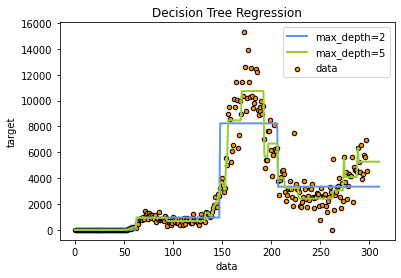

In [168]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset

X = np.array(florida_cases_.index).reshape(-1, 1)
y = np.array(florida_cases_.Cases).reshape(-1, 1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0, 311, 1)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()
# fig.write_image("images/fig5.png")


In [169]:
# plt.figure(figsize=(16, 8))
# plt.scatter(X, y, c='steelblue',                  # Plot actual target against features
#             edgecolor='white', s=70)
# plt.plot(X, tree.predict(X),                      # Plot predicted target against features
#          color='black', lw=2)
# plt.show()

In [203]:
rmse = np.sqrt(mean_squared_error(x_range, y_range))
print(f"The RMSE for DT is {rmse}")

The RMSE for DT is 157.90731085373952


#### Utilize random forest

In [171]:
from sklearn.ensemble import RandomForestRegressor
from numpy import asarray


In [172]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train.index, train
    
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

<ipython-input-173-340f23494491>:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



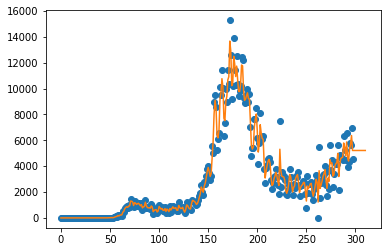

In [173]:
test = np.array([i for i in range(311)]).reshape(-1,1)
model = RandomForestRegressor()
model.fit(X, y)

# Plot the data and the model prediction
X_fit = test
y_fit = model.predict(X_fit)

plt.plot(X.squeeze(), y, 'o')
plt.plot(X_fit.squeeze(), y_fit);
# plt.plot(X_fit.squeeze(), y_fit);

In [205]:
rmse = np.sqrt(mean_squared_error(x_range, y_range))
print(f"The RMSE for RF is {rmse}")

The RMSE for RF is 157.90731085373952


#### Utilize ARIMA 

In [177]:
florida_cases[0]

2020-01-22       0.0
2020-01-23       0.0
2020-01-24       0.0
2020-01-25       0.0
2020-01-26       0.0
               ...  
2020-11-10    4354.0
2020-11-11    5803.0
2020-11-12    5612.0
2020-11-13    6934.0
2020-11-14    4524.0
Name: 0, Length: 298, dtype: float64

<ipython-input-179-e492ba13f602>:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

C:\Users\CodingTheories\Anaconda3\envs\CSC_405\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\C

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  297
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2491.658
Method:                       css-mle   S.D. of innovations           1063.393
Date:                Sun, 15 Nov 2020   AIC                           4997.315
Time:                        21:12:36   BIC                           5023.172
Sample:                    01-23-2020   HQIC                          5007.667
                         - 11-14-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7779     22.249      0.799      0.424     -25.830      61.385
ar.L1.D.y     -0.5263      0.056     -9.355      0.000      -0.637      -0.416
ar.L2.D.y     -0.3804      0.062     -6.138      0.0

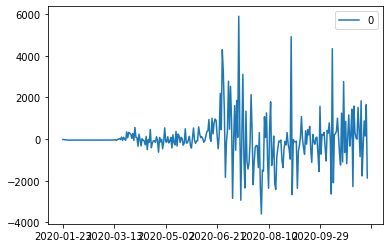

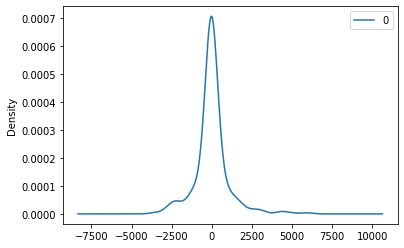

                 0
count   297.000000
mean     -0.226130
std    1065.188313
min   -3590.846573
25%    -247.494873
50%     -49.588188
75%     226.237180
max    5893.210493


In [179]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot



series = florida_cases[0]
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

C:\Users\CodingTheories\Anaconda3\envs\CSC_405\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




predicted=7100.305551, expected=5422.000000
predicted=6100.793053, expected=7667.000000
predicted=8028.209740, expected=7657.000000
predicted=7467.371363, expected=8499.000000
predicted=7536.540650, expected=6212.000000
predicted=6259.988326, expected=4153.000000
predicted=4628.662548, expected=5807.000000
predicted=6727.082519, expected=8127.000000
predicted=7891.883934, expected=6219.000000
predicted=6413.319590, expected=6133.000000
predicted=6492.630174, expected=6328.000000
predicted=6131.712249, expected=3766.000000
predicted=4193.716573, expected=2673.000000
predicted=4512.064265, expected=3832.000000
predicted=4752.482692, expected=4112.000000
predicted=4388.933284, expected=4543.000000
predicted=4991.319027, expected=4670.000000
predicted=4553.615330, expected=4287.000000
predicted=3874.431407, expected=2966.000000
predicted=3278.309170, expected=2250.000000
predicted=2904.418292, expected=2663.000000
predicted=3278.465422, expected=3195.000000
predicted=3516.260343, expected=

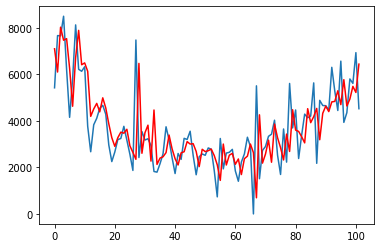

In [176]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % np.sqrt(error))
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
# fig.write_image("images/fig1.png")